In [1]:
import sys
sys.path.append('../')  # Go up one level from 'notebooks' to 'lppls'

Estimated bubble start time (tau): 0.3031674208144796


/Users/josheejames/projects/lppls/notebooks/../lppls/lppls.py:620: RuntimeWarning: invalid value encountered in log
  return (w / (2.0 * np.pi)) * np.log((tc - t1) / (tc - t2))


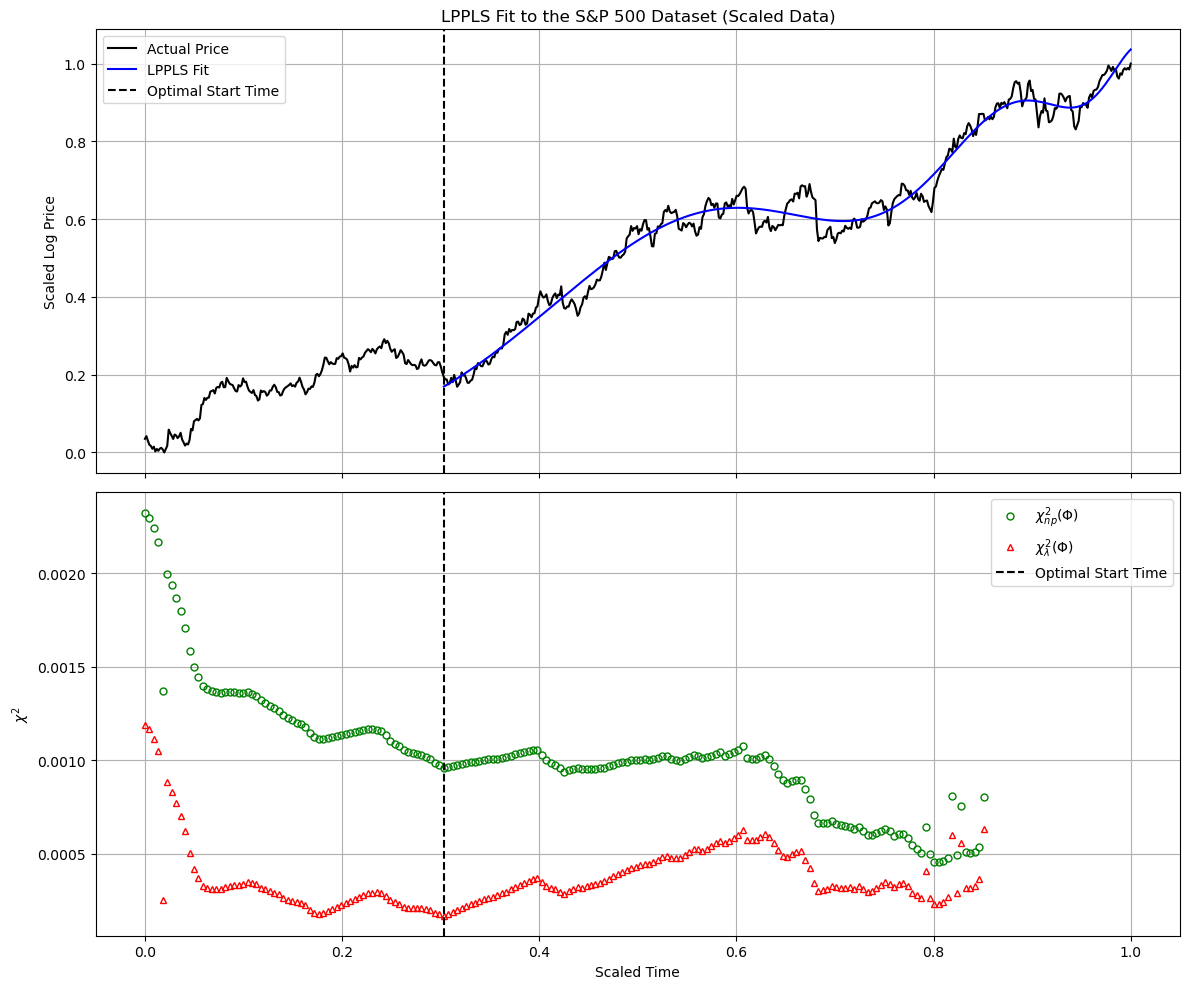

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lppls import lppls_lm
import yfinance as yf
import os

FILE_NAME = 'sp500.csv'

if not os.path.exists(FILE_NAME):
    ticker_symbol = "^GSPC"    # S&P 500
    start_date = "1984-11-25"  # Start date from the paper
    end_date = "1987-07-15"    # End date from the paper

    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    data.to_csv(FILE_NAME, index=False)
else:
    data = pd.read_csv(FILE_NAME)

time = np.arange(len(data))
time_scaled = (time - time.min()) / (time.max() - time.min())
price = np.log(data['Adj Close'].values)
price_scaled = (price - price.min()) / (price.max() - price.min())
observations = np.array([time_scaled, price_scaled])
lppls_model = lppls_lm.LPPLS(observations)

# detect bubble start time via Lagrange regularization
# https://arxiv.org/pdf/1707.07162
result = lppls_model.detect_bubble_start_time_via_lagrange(
    max_window_size=len(time),
    min_window_size=100,
    step_size=3,
    max_searches=25
)

if result:
    tau = result['tau']
    print(f"Estimated bubble start time (tau): {tau}")
    tc = result['tc']
    m = result['m']
    w = result['w']
    a = result['a']
    b = result['b']
    c1 = result['c1']
    c2 = result['c2']

    window_sizes = result['window_sizes']
    sse_list = result['sse_list']
    ssen_list = result['ssen_list']
    lagrange_sse_list = result['lagrange_sse_list']
    start_times = result['start_times']

    window_sizes_np = np.array(window_sizes)
    sse_np = np.array(sse_list)
    ssen_np = np.array(ssen_list)
    lagrange_sse_np = np.array(lagrange_sse_list)
    start_times_np = np.array(start_times)

    # extract the optimal window data
    optimal_window_size = result['optimal_window_size']
    start_idx = len(time_scaled) - optimal_window_size
    end_idx = len(time_scaled)
    time_fit = time_scaled[start_idx:end_idx]
    price_fit = price_scaled[start_idx:end_idx]

    # compute the LPPLS fit over the optimal window
    predictions = lppls_model.lppls(time_fit, tc, m, w, a, b, c1, c2)

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # top subplot: plot the data and the LPPLS fit
    axs[0].plot(time_scaled, price_scaled, label='Actual Price', color='black')
    axs[0].plot(time_fit, predictions, label='LPPLS Fit', color='blue')

    tau_time = time_scaled[start_idx]
    axs[0].axvline(x=tau_time, color='black', linestyle='--', label='Optimal Start Time')
    if time_scaled.min() <= tc <= time_scaled.max():
        axs[0].axvline(x=tc, color='green', linestyle='--', label='Critical Time (tc)')

    axs[0].set_title('LPPLS Fit to the S&P 500 Dataset (Scaled Data)')
    axs[0].set_ylabel('Scaled Log Price')
    axs[0].legend()
    axs[0].grid(True)

    # bottom subplot: plot χ²_np(Φ) and χ²_λ(Φ) against start times
    axs[1].plot(start_times_np, ssen_np, 'o', label=r'$\chi^2_{np}(\Phi)$', color='green', markersize=5, markerfacecolor='none')
    axs[1].plot(start_times_np, lagrange_sse_np, '^', label=r'$\chi^2_{\lambda}(\Phi)$', color='red', markersize=5, markerfacecolor='none')

    # optimal start time
    axs[1].axvline(x=tau_time, color='black', linestyle='--', label='Optimal Start Time')

    axs[1].set_xlabel('Scaled Time')
    axs[1].set_ylabel(r'$\chi^2$')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Could not estimate the bubble start time.")


In [3]:
print(result)

{'tau': 0.3031674208144796, 'optimal_window_size': 463, 'tc': 1.093783326857828, 'm': 0.6795605217680599, 'w': 6.909571313976674, 'a': 1.22773696010819, 'b': -1.0996918043446704, 'c1': -0.06937040681764274, 'c2': 0.14586194730771954, 'window_sizes': [664, 661, 658, 655, 652, 649, 646, 643, 640, 637, 634, 631, 628, 625, 622, 619, 616, 613, 610, 607, 604, 601, 598, 595, 592, 589, 586, 583, 580, 577, 574, 571, 568, 565, 562, 559, 556, 553, 550, 547, 544, 541, 538, 535, 532, 529, 526, 523, 520, 517, 514, 511, 508, 505, 502, 499, 496, 493, 490, 487, 484, 481, 478, 475, 472, 469, 466, 463, 460, 457, 454, 451, 448, 445, 442, 439, 436, 433, 430, 427, 424, 421, 418, 415, 412, 409, 406, 403, 400, 397, 394, 391, 388, 385, 382, 379, 376, 373, 370, 367, 364, 361, 358, 355, 352, 349, 346, 343, 340, 337, 334, 331, 328, 325, 322, 319, 316, 313, 310, 307, 304, 301, 298, 295, 292, 289, 286, 283, 280, 277, 274, 271, 268, 265, 262, 259, 256, 253, 250, 247, 244, 241, 238, 235, 232, 229, 226, 223, 220, 217,